In [2]:
import scanpy as sc
import pandas as pd

In [3]:
# https://cellxgene.cziscience.com/collections/8f17ac63-aaba-44b5-9b78-60f121da4c2f 
adata = sc.read_h5ad("/home/augusta/SSS_mount/insituCNV/data/vascular_normal_master.h5ad")

In [4]:
# Add raw layer
adata.layers['counts'] = adata.raw.X

In [6]:
adata.obs.donor_id.head(5)

AAACGAAAGACTCATC-1    patient1
AAACGAACAACGACTT-1    patient1
AAACGAACAATCGCCG-1    patient1
AAACGCTCAGCAGGAT-1    patient1
AAACGCTTCCGTGTCT-1    patient1
Name: donor_id, dtype: category
Categories (6, object): ['patient1', 'patient2', 'patient3', 'patient4', 'patient5', 'patient6']

In [7]:
adata.obs.cell_type.head(5)

AAACGAAAGACTCATC-1                                        macrophage
AAACGAACAACGACTT-1                                        macrophage
AAACGAACAATCGCCG-1    microcirculation associated smooth muscle cell
AAACGCTCAGCAGGAT-1                                        fibroblast
AAACGCTTCCGTGTCT-1                                        macrophage
Name: cell_type, dtype: category
Categories (7, object): ['fibroblast', 'macrophage', 'lymphocyte', 'microcirculation associated smooth muscle cell', 'blood vessel smooth muscle cell', 'endothelial cell of artery', 'unknown']

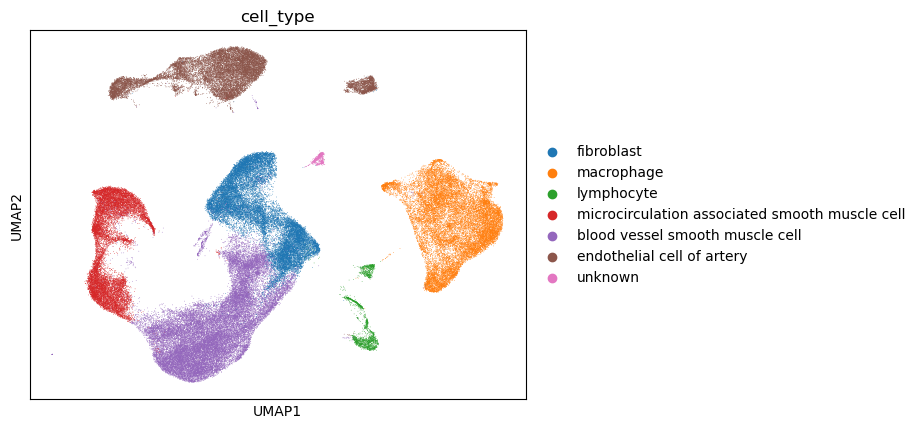

In [8]:
sc.pl.umap(adata, color = 'cell_type')

## Filter data
- one donor (patient 1)
- two cell types (macrophage, fibroblast)

In [9]:
adata_sub = adata[adata.obs.donor_id == 'patient1']

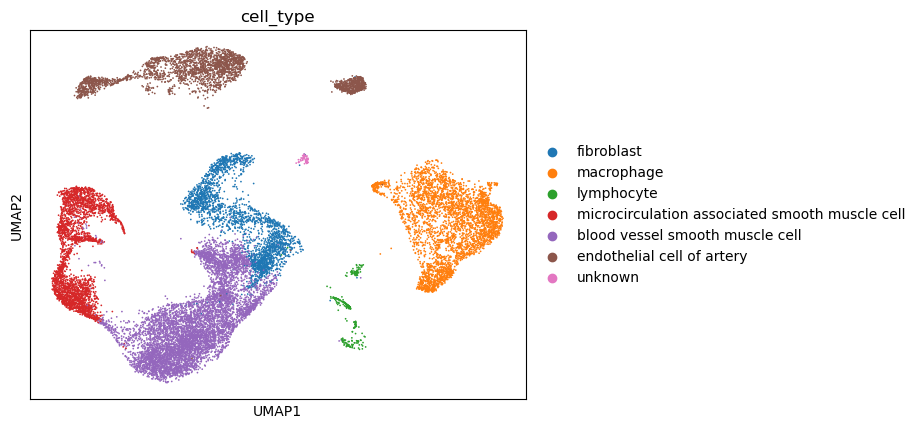

In [10]:
sc.pl.umap(adata_sub, color = 'cell_type')

In [11]:
adata.var.head(5)

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type
ENSG00000243485,True,MIR1302-2HG,NCBITaxon:9606,gene,623,lncRNA
ENSG00000237613,True,FAM138A,NCBITaxon:9606,gene,888,lncRNA
ENSG00000186092,True,OR4F5,NCBITaxon:9606,gene,2618,protein_coding
ENSG00000238009,False,ENSG00000238009.6,NCBITaxon:9606,gene,629,lncRNA
ENSG00000239945,False,ENSG00000239945.1,NCBITaxon:9606,gene,1319,lncRNA


In [14]:
len(adata_sub.var_names)

33159

In [15]:
# Remove genes that have been filtered
adata_sub_filtered = adata_sub[:, adata_sub.var['feature_is_filtered']== False]

In [16]:
len(adata_sub_filtered.var_names)

22798

In [17]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata_sub_filtered, inplace=True)

/home/augusta/anaconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:141: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [18]:
adata_sub_filtered.var['total_counts'].mean()

2720.369

In [19]:
adata_sub_filtered.var.head(5)

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
ENSG00000238009,False,ENSG00000238009.6,NCBITaxon:9606,gene,629,lncRNA,124,0.002960,0.002956,99.357879,57.168095,4.063337
ENSG00000239945,False,ENSG00000239945.1,NCBITaxon:9606,gene,1319,lncRNA,7,0.000155,0.000155,99.963751,3.001719,1.386724
ENSG00000237491,False,LINC01409,NCBITaxon:9606,gene,1059,lncRNA,1365,0.035948,0.035317,92.931490,694.189636,6.544185
ENSG00000177757,False,FAM87B,NCBITaxon:9606,gene,1947,lncRNA,112,0.002560,0.002557,99.420020,49.439869,3.920782
ENSG00000225880,False,LINC00115,NCBITaxon:9606,gene,3312,lncRNA,479,0.012538,0.012460,97.519548,242.123749,5.493571


In [20]:
adata_sub_filtered.var['n_cells_by_counts'].mean()

3116.586411088692

In [21]:
adata_sub_filtered.obs['total_counts'].mean()

3211.587

## Add genomic positions

In [22]:

def add_genomic_positions(adata):
    ''' Adds gene positions to the AnnData object. The adata.var_names have to be EnsmblIDs. The data is taken from the Ensmbl BioMart human dataset GRCh38.p14. 

    param:
        adata (AnnData object): the annotated dataset where the gene postions should be added
    output: 
        adata (AnnData object): the annotated dataset where the genes are added
 
    '''

    
    # Load the gene positions data
    gene_file = "/home/augusta/SSS_mount/insituCNV/InSituCNV/Ensmbl_BioMart_gene_info.txt"
    gene_positions_df = pd.read_csv(gene_file)

    # Create a dictionary for quick lookup
    gene_dict = gene_positions_df.set_index("Gene stable ID")[["Chromosome/scaffold name", "Gene start (bp)", "Gene end (bp)"]].to_dict("index")

    # Format chromosome names
    format_chromosome = lambda x: f"chr{x}"

    # Initialize counters
    genes_identified = 0

    # Iterate over the genes in adata
    for gene_id in adata.var_names:
        if gene_id in gene_dict:
            info = gene_dict[gene_id]
            adata.var.loc[gene_id, ["chromosome", "start", "end"]] = [format_chromosome(info["Chromosome/scaffold name"]), info["Gene start (bp)"], info["Gene end (bp)"]]
            genes_identified += 1

    # Print summary of identified genes
    print(f"{genes_identified} gene positions identified \n{adata.shape[1] - genes_identified} were not found")
    return adata

In [23]:
add_genomic_positions(adata_sub_filtered)

22015 gene positions identified 
783 were not found


AnnData object with n_obs × n_vars = 19311 × 22798
    obs: 'mapped_reference_annotation', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_derivation_process', 'donor_BMI_at_collection', 'tissue_type', 'suspension_derivation_process', 'suspension_dissociation_reagent', 'suspension_dissociation_time', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'sequencing_platform', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct

In [24]:
adata_sub_filtered.write("/home/augusta/SSS_mount/insituCNV/data/vascular_normal_all_celltypes.h5ad", compression = 'gzip')